In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [182]:
class Value:

    def __init__(self, data, _children=(), _op='', _label=''):
        self._prev = set(_children)
        self._op = _op
        self._label = _label
        self._backward = lambda: None
        self.data = data
        self.grad = 0.0

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def __add__(self, other: "Value"):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # our job is to propagate the gradient of out with respect to all the inputs to the previous nodes
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __radd__(self, other): #other + self
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return other + (-self)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def __rmul__(self, other): #other * self
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float powers"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad

        out._backward = _backward
        return out
    
    def __rpow__(self, other):
        return Value(other**self.data, (self, ), f'**{other}')

    def __truediv__(self, other): #self/other
        return self * other**-1

    def __rtruediv__(self, other): #other/self
        return other * self**-1
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - out.data**2) * out.grad
            
        out._backward = _backward
        return out

    def __repr__(self):
        return f"Value(data={self.data})"
        

In [ ]:
from graphviz import Digraph

def trace(root):
    #builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    nodes, edges = trace(root)
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR = left to right
    
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n._label, n.data, n.grad), shape='record')
        if n._op:
            # only add this node if it has an operation associated with it
            dot.node(name = uid+n._op, label = n._op)
            dot.edge(uid+n._op, uid)

    for n1, n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [184]:
x1 = Value(2.0, _label='x1')
x2 = Value(0.0, _label='x2')
#weights w1,w2
w1 = Value(-3.0, _label='w1')
w2 = Value(1.0, _label='w2')
#bias
b = Value(6.8813735870195432, _label='b')
x1w1 = x1*w1; x1w1._label = 'x1w1'
x2w2 = x2*w2; x2w2._label = 'x2w2'
#x1w1 + x2w2 + bias
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n._label = 'n'
#------------------------------
e = (2*n).exp(); e._label = 'e'
o = (e-1)/(e+1); o._label = 'o'
#------------------------------
o.grad = 1.0
o.backward()



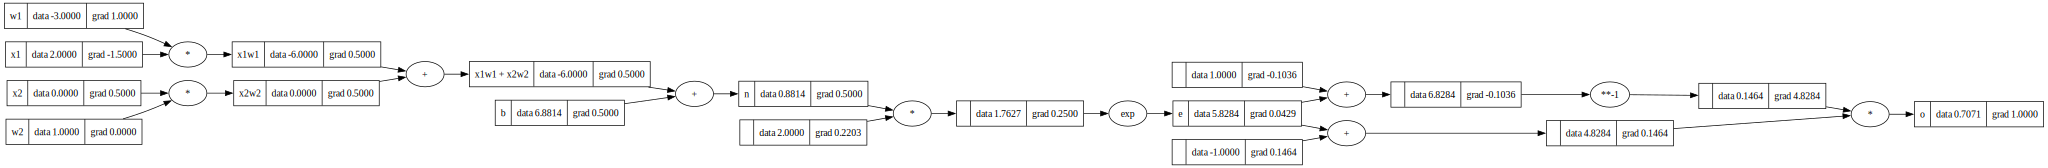

In [185]:
draw_dot(o)


In [187]:
import torch

x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item()) # takes the data from the tensor and converts it to a python number
o.backward()

print (' --- ')
print('x2', x2.grad.item()) 
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

torch.Tensor([[1, 2, 3], [4, 5, 6]]).shape

0.7071066904050358
 --- 
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


torch.Size([2, 3])

In [188]:
o.item()

0.7071066904050358